# Ticketing system 

# 1. Import Libraries

In [19]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import Tf
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import camel_tools.utils.normalize as norm
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.charmap import CharMapper
import camel_tools.utils.normalize as normalize
from camel_tools.tokenizers.word import simple_word_tokenize
from nltk.tokenize import word_tokenize
from datetime import datetime
from camel_tools.utils import normalize

import camel_tools.utils.normalize as normalize
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import joblib


[nltk_data] Downloading package stopwords to /home/norhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/norhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load the dataset
data = pd.read_excel('/home/norhan/Downloads/SIGMA/Book1.xlsx')


# Display the first few rows to verify the data
print("First few rows of the dataset:")
print(data.head())


First few rows of the dataset:
     No.          Date  1st-Response Date  Close Date  \
0  35209  44742.583333       44742.588889         NaN   
1  35185  44742.384722       44742.407639         NaN   
2  35182  44742.328472       44742.338889         NaN   
3  35163  44741.500000       44741.501389         NaN   
4  35158  44741.470139       44741.477083  44742.5625   

                                        Request Type  \
0     MOH Central IT General : End User Devices : PC   
1                     MOH Central IT General : Other   
2  MOH Central IT General : Network : New Network...   
3     MOH Central IT General : End User Devices : PC   
4      MOH Central IT General : Security : Kaspersky   

                                             Subject  \
0  طلب اصلاح جهاز بعيادة العظام - مستشفى السليل ا...   
1  إعادة توجيه: إعادة توجيه: احتياج المستشفى من ا...   
2                      انشاء 10 نقاط جديدة بشكل عاجل   
3                                         PC BROBLEM   
4        

In [4]:
# Show basic statistics
data.describe()


,No.,Date,1st-Response Date,Close Date
count,1063.000000,1063.000000,1063.000000,943.000000
mean,31442.286924,44652.014522,44651.944302,44657.612663
std,2117.458564,53.329518,53.422992,53.065196
min,27530.000000,44563.404861,44537.852083,44564.570139
25%,29817.000000,44606.973958,44606.735417,44614.030903
50%,31411.000000,44644.586806,44644.588194,44649.586111
75%,33163.500000,44700.397569,44700.397917,44705.647222
max,35209.000000,44742.583333,44742.588889,44743.654167


#  2. Handle date columns


In [5]:
date_cols = ['Date', '1st-Response Date', 'Close Date']

for col in date_cols:
    # Check if the column is numeric (Excel-style dates)
    if pd.api.types.is_numeric_dtype(data[col]):
        # Convert numeric date to datetime using Excel origin
        data[col] = pd.to_datetime(data[col], errors='coerce', unit='d', origin='1899-12-30')
    else:
        # Convert other formats (strings or already datetime) to datetime
        data[col] = pd.to_datetime(data[col], errors='coerce')



###  *Now the 'Date', '1st-Response Date', and 'Close Date' columns should all be in datetime format*

# 3. Data Cleaning Functions


In [6]:

# 2.1 General function to clean both Arabic and English text
def clean_text(text):
    # Remove extra spaces, unwanted characters (email disclaimers, HTML tags, etc.)
    text = re.sub(r'<.*?>', '', str(text))  # Remove HTML tags
    text = re.sub(r'\[.*?\]', '', text)  # Remove content in square brackets
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

# 2.2 Manual normalization function for Arabic text
def manual_arabic_normalization(text):
    # Custom normalization logic (e.g., replace different forms of Alef and Teh)
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')  # Normalize Alef forms
    text = text.replace('ة', 'ت')  # Normalize Teh forms if needed
    # Add more normalization rules as needed
    return text

# 2.3 Function to clean Arabic text
def clean_arabic_text(text):
    text = clean_text(text)
    text = manual_arabic_normalization(text)  # Use the manual normalization
    return text

# 2.4 Function to clean English text using NLTK
def clean_english_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)  # Tokenize English text
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]  # Remove English stopwords
    return ' '.join(tokens)



#  4. Apply Cleaning Functions


In [7]:
text_columns = ['Request Type', 'Subject', 'Request Detail', 'Notes']
for col in text_columns:
    data[col] = data[col].apply(
        lambda x: clean_arabic_text(x) if re.search(r'[\u0600-\u06FF]', str(x)) else clean_english_text(x)
    )
# Verify cleaning
print("\nData after cleaning:")
print(data[text_columns].head())



Data after cleaning:
                                        Request Type  \
0        MOH Central General : End User Devices : PC   
1                              MOH Central General :   
2  MOH Central General : Network : New Network Po...   
3        MOH Central General : End User Devices : PC   
4         MOH Central General : Security : Kaspersky   

                                             Subject  \
0  طلب اصلاح جهاز بعيادت العظام - مستشفى السليل ا...   
1  اعادت توجيه: اعادت توجيه: احتياج المستشفى من ا...   
2                      انشاء 10 نقاط جديدت بشكل عاجل   
3                                         PC BROBLEM   
4             تحديث برنامج كاسبر _مستشفى شقراء العام   

                                      Request Detail  \
0  *** This is an external email. Be Vigilant and...   
1  *** This is an external email. Be Vigilant and...   
2  *** This is an external email. Be Vigilant and...   
3  *** This is an external email. Be Vigilant and...   
4  *** This is an extern

# 5. EDA

#### 5.1 Document 3-5 Major Insights from the Data


In [8]:
def extract_insights(data):
    insights = []
    
    # Insight 1: Most common Request Types
    common_request_types = data['Request Type'].value_counts().head(5)
    insights.append("Insight 1: Top 5 most common Request Types:\n" + str(common_request_types))
    
    # Insight 2: Distribution of Priorities
    priority_distribution = data['Priority'].value_counts()
    insights.append("Insight 2: Priority distribution:\n" + str(priority_distribution))
    
    # Insight 3: Average response time
    # Compute 'Response Time' only for rows where 'Close Date' is not NaT
    data['Response Time'] = (data['Close Date'] - data['1st-Response Date']).dt.days
    avg_response_time = data['Response Time'].mean()
    insights.append(f"Insight 3: Average response time: {avg_response_time:.2f} days")
    
    # Insight 4: Most common companies
    common_companies = data['Company'].value_counts().head(5)
    insights.append("Insight 4: Top 5 companies with most requests:\n" + str(common_companies))
    
    # Insight 5: Status distribution
    status_distribution = data['Status'].value_counts()
    insights.append("Insight 5: Status distribution:\n" + str(status_distribution))
    
    return insights

insights = extract_insights(data)
print("\nMajor Insights:")
for insight in insights:
    print(insight + "\n")


Major Insights:
Insight 1: Top 5 most common Request Types:
Request Type
MOH Central General : End User Devices : Printer    232
MOH Central General : End User Devices : PC         187
MOH Central General : Network : Configuration       112
MOH Central General :                                97
MOH Central General : Network : Internet Problem     53
Name: count, dtype: int64

Insight 2: Priority distribution:
Priority
Medium    1052
Urgent       8
High         3
Name: count, dtype: int64

Insight 3: Average response time: 9.74 days

Insight 4: Top 5 companies with most requests:
Company
MOH-MIS-Riyadh    783
MOH-MIS-Qassim    280
Name: count, dtype: int64

Insight 5: Status distribution:
Status
Closed                         918
In Progress/Awaiting Part       77
In Progress                     34
Cancelled                       25
Awaiting Customer                5
In Progress/Awaiting Vendor      4
Name: count, dtype: int64



#### 5.2 Show Words Most Used in “Request Detail” Feature


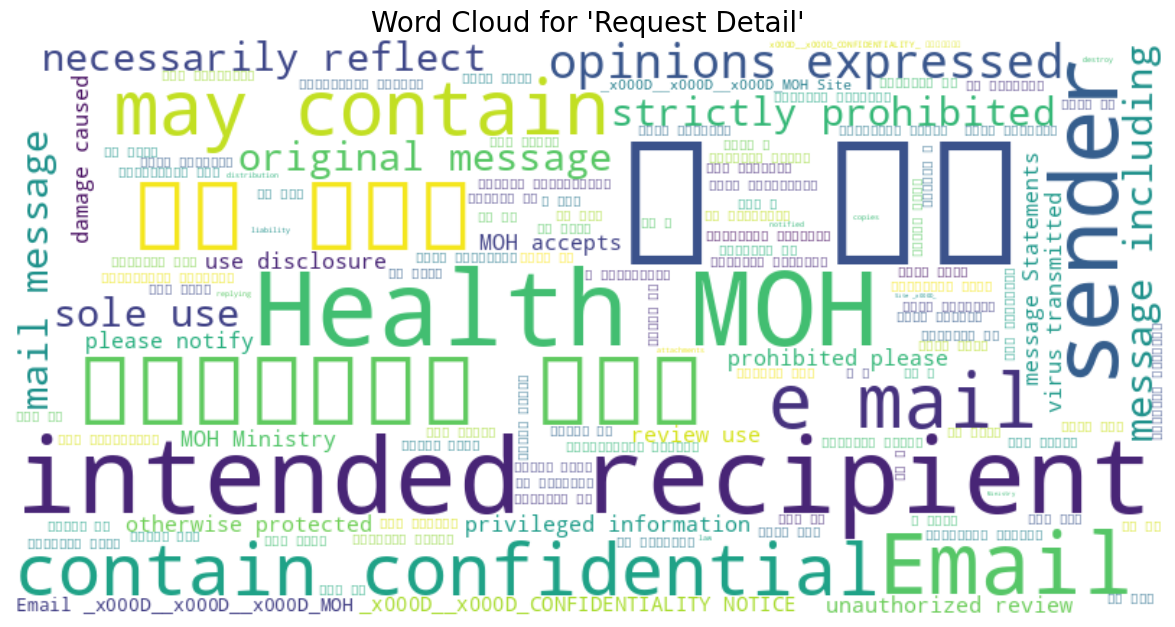

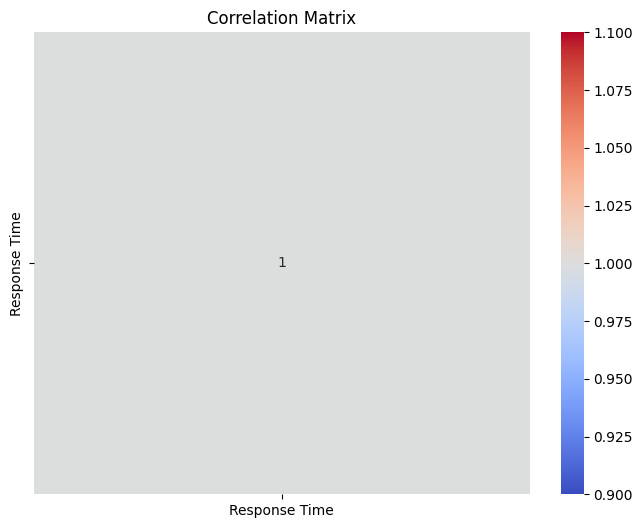

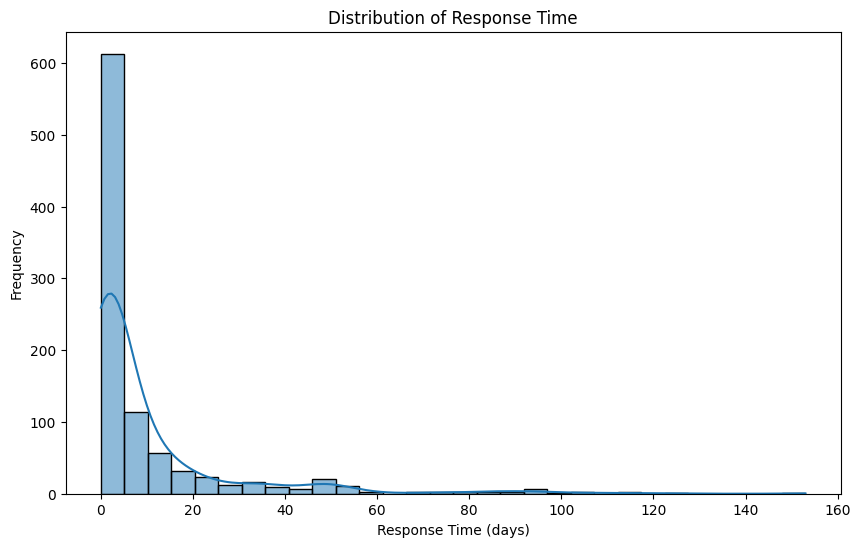

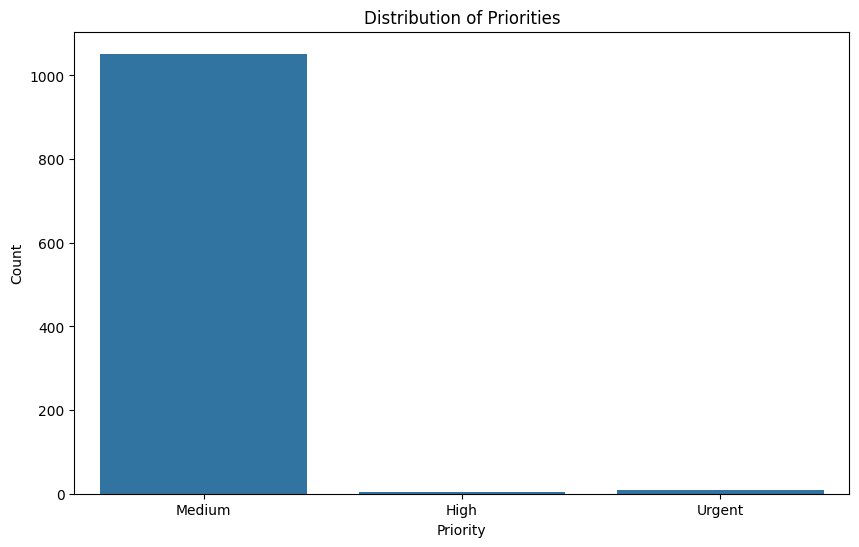

In [9]:

# Combine all text from 'Request Detail'
request_detail_text = ' '.join(data['Request Detail'].dropna().tolist())

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords.words('english')).generate(request_detail_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for 'Request Detail'", fontsize=20)
plt.show()

# 4.3 Study Correlation

# Select numerical columns for correlation
numerical_cols = ['Response Time']
if 'Response Time' in data.columns:
    corr_matrix = data[numerical_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()
else:
    print("No numerical columns available for correlation analysis.")

# 4.4 Show Distributions and Demographics of Data

# Distribution of Response Time
if 'Response Time' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Response Time'].dropna(), bins=30, kde=True)
    plt.title("Distribution of Response Time")
    plt.xlabel("Response Time (days)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("Response Time column not found.")

# Distribution of Priorities
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Priority')
plt.title("Distribution of Priorities")
plt.xlabel("Priority")
plt.ylabel("Count")
plt.show()


#### 5.5 Show Statistical Metrics


In [11]:

# Statistical summary
print("\nStatistical Summary:")
print(data.describe(include='all'))




Statistical Summary:
                 No.                           Date  \
count    1063.000000                           1063   
unique           NaN                            NaN   
top              NaN                            NaN   
freq             NaN                            NaN   
mean    31442.286924  2022-04-01 00:20:54.694261504   
min     27530.000000  2022-01-02 09:43:00.000000240   
25%     29817.000000            2022-02-14 23:22:30   
50%     31411.000000            2022-03-24 14:05:00   
75%     33163.500000  2022-05-19 09:32:30.000000256   
max     35209.000000  2022-06-30 14:00:00.000000213   
std      2117.458564                            NaN   

                    1st-Response Date                     Close Date  \
count                            1063                            943   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                         

# 6. Feature Engineering


In [13]:

# 5.1 Combine 'Request Detail' and 'Notes' for feature extraction
data['combined_text'] = data['Request Detail'] + " " + data['Notes']

# Handle NaN values in 'combined_text'
data['combined_text'] = data['combined_text'].fillna('')  # Fill NaN with an empty string



In [14]:
# 5.2 Feature Extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_text'])
tfidf_features = tfidf_matrix.toarray()



In [15]:
# 5.3 Feature Extraction using Count Vectorizer
count_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
count_matrix = count_vectorizer.fit_transform(data['combined_text'])
count_features = count_matrix.toarray()



In [16]:
# 5.4 Feature Extraction using BERT Embeddings
# Note: BERT processing can be time-consuming. Ensure you have sufficient computational resources.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def compute_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

print("\nComputing BERT embeddings. This may take a while...")
bert_embeddings = compute_bert_embeddings(data['combined_text'].tolist())
print("BERT embeddings computed.")

# 5.5 Create DataFrames for features
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
count_feature_names = count_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_feature_names)
count_df = pd.DataFrame(count_features, columns=count_feature_names)
bert_df = pd.DataFrame(bert_embeddings, columns=[f'bert_{i}' for i in range(bert_embeddings.shape[1])])

# 5.6 Concatenate all features into a single DataFrame
features_df = pd.concat([tfidf_df, count_df, bert_df], axis=1)

# Convert all column names to strings to avoid TypeError
features_df.columns = features_df.columns.astype(str)

# Display the shape of the final features DataFrame
print(f'\nFinal features shape: {features_df.shape}')


Computing BERT embeddings. This may take a while...
BERT embeddings computed.

Final features shape: (1063, 2768)


# 7. Clustering to Generate Labels



Calculating silhouette scores for different numbers of clusters...
For n_clusters = 2, the average silhouette_score is : 0.7232
For n_clusters = 3, the average silhouette_score is : 0.5769
For n_clusters = 4, the average silhouette_score is : 0.4370
For n_clusters = 5, the average silhouette_score is : 0.3884
For n_clusters = 6, the average silhouette_score is : 0.3261
For n_clusters = 7, the average silhouette_score is : 0.3114
For n_clusters = 8, the average silhouette_score is : 0.2376
For n_clusters = 9, the average silhouette_score is : 0.2322


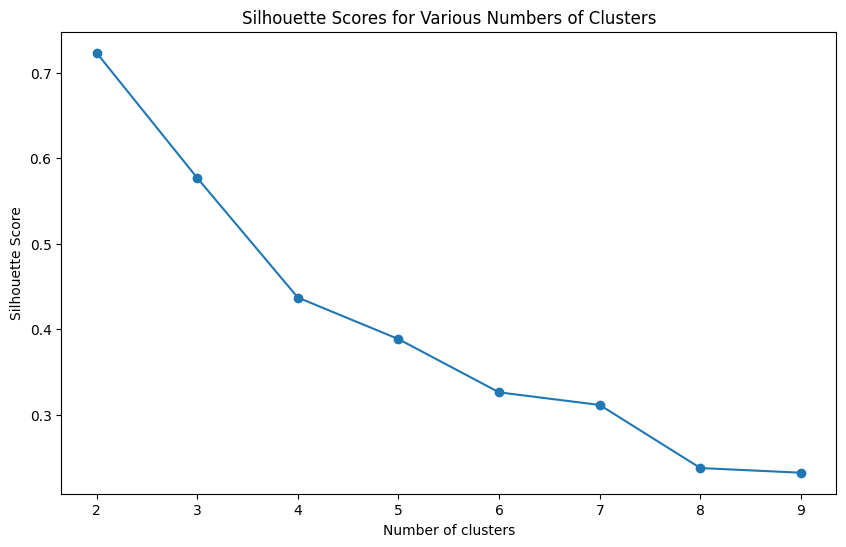


Optimal number of clusters based on silhouette score: 2

Cluster distribution:
Cluster
0    741
2    163
1    159
Name: count, dtype: int64


In [17]:

# 6.1 Choose Number of Clusters
# You can determine the optimal number of clusters using the Elbow method or Silhouette Score.
# Here, we'll use the Silhouette Score to find a suitable number of clusters.

silhouette_scores = {}
range_n_clusters = list(range(2, 10))  # Trying 2 to 9 clusters

print("\nCalculating silhouette scores for different numbers of clusters...")
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(bert_embeddings)  # Using BERT embeddings for clustering
    silhouette_avg = silhouette_score(bert_embeddings, cluster_labels)
    silhouette_scores[n_clusters] = silhouette_avg
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Scores for Various Numbers of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range_n_clusters)
plt.show()

# Choose the number of clusters with the highest silhouette score
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nOptimal number of clusters based on silhouette score: {optimal_clusters}")

# 6.2 Apply KMeans with Optimal Clusters ,and try 3
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(bert_embeddings)

# Verify cluster distribution
print("\nCluster distribution:")
print(data['Cluster'].value_counts())


# 8. Train-Test Split


In [20]:

# Choose the cluster labels as y
X = features_df
y = data['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# 9. Modeling


In [21]:

# 9.1 Logistic Regression
log_reg = LogisticRegression(max_iter=1000)

# Convert X_train and X_test to DataFrames with string column names
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)



In [22]:
# 9.2 Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)

In [ ]:
# 9.3 Transformer-based Model (BERT for Classification)
# Note: Transformer-based models are more complex and require a different approach.
# Here, we'll use Hugging Face's Trainer API.

from transformers import Trainer, TrainingArguments, BertForSequenceClassification
from torch.utils.data import Dataset

class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Initialize tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_texts = data.loc[X_train.index, 'combined_text'].tolist()
train_labels = y_train.tolist()
test_texts = data.loc[X_test.index, 'combined_text'].tolist()
test_labels = y_test.tolist()

train_dataset_bert = TicketDataset(train_texts, train_labels, bert_tokenizer)
test_dataset_bert = TicketDataset(test_texts, test_labels, bert_tokenizer)

# Initialize BERT model for classification
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=optimal_clusters)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./bert_logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=2,  # Keep only the last 2 checkpoints
)

# Define compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(p.label_ids, preds)
    prec = precision_score(p.label_ids, preds, average='weighted')
    rec = recall_score(p.label_ids, preds, average='weighted')
    return {'accuracy': acc, 'precision': prec, 'recall': rec}

# Initialize Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    compute_metrics=compute_metrics
)

# Train the BERT model
print("\nTraining BERT model...")
trainer.train()

# Evaluate the BERT model
bert_eval = trainer.evaluate()
print("\nBERT Model Evaluation:")
print(bert_eval)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Training BERT model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.018800,0.017176,0.995305,0.995429,0.995305
2,0.016300,0.019567,0.995305,0.995429,0.995305
3,0.000300,0.014595,0.995305,0.995332,0.995305



BERT Model Evaluation:
{'eval_loss': 0.01717551052570343, 'eval_accuracy': 0.9953051643192489, 'eval_precision': 0.9954287126266371, 'eval_recall': 0.9953051643192489, 'eval_runtime': 7.9985, 'eval_samples_per_second': 26.63, 'eval_steps_per_second': 3.376, 'epoch': 3.0}


# 10. Evaluation


In [25]:

# 9.1 Evaluation Metrics for Logistic Regression
print("\nLogistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, log_reg_pred):.2f}")
print(f"Precision: {precision_score(y_test, log_reg_pred, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, log_reg_pred, average='weighted'):.2f}")
print("Classification Report:")
print(classification_report(y_test, log_reg_pred))

# 9.2 Evaluation Metrics for Random Forest
print("\nRandom Forest Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.2f}")
print(f"Precision: {precision_score(y_test, rf_pred, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, rf_pred, average='weighted'):.2f}")
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# 9.3 Evaluation Metrics for BERT (Already printed above)




Logistic Regression Evaluation:
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       142
           1       0.97      1.00      0.99        33
           2       0.97      0.89      0.93        38

    accuracy                           0.98       213
   macro avg       0.97      0.96      0.97       213
weighted avg       0.98      0.98      0.98       213


Random Forest Evaluation:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       142
           1       1.00      1.00      1.00        33
           2       1.00      0.97      0.99        38

    accuracy                           1.00       213
   macro avg       1.00      0.99      0.99       213
weighted avg       1.00      1.00      1.00       213



# 11. Feature Importance (Using Random Forest)


/tmp/ipykernel_25294/61585760.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=top_features, palette='viridis')


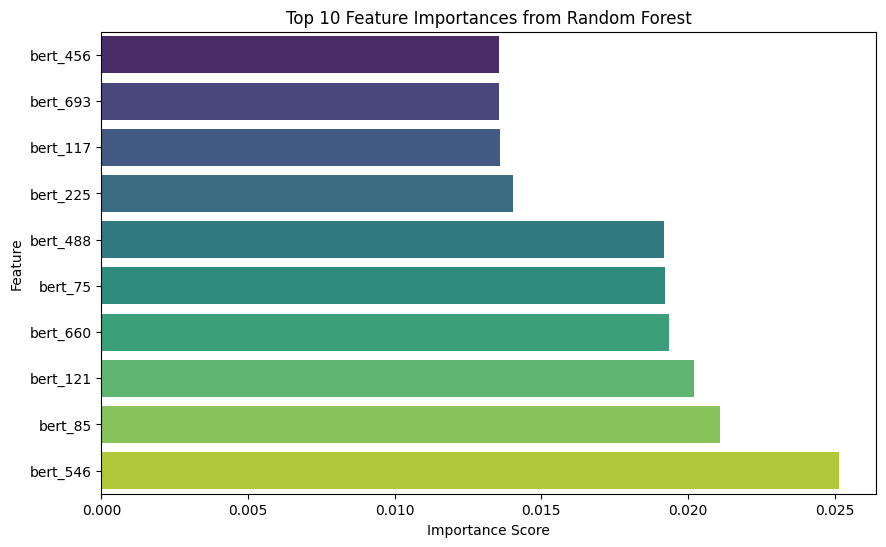

In [26]:

importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

# Get feature names
feature_names = X.columns.tolist()
top_features = [feature_names[i] for i in indices]

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=top_features, palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# 12. Save Models and Encoders 


In [27]:

# Save label encoders (Not needed since labels are clusters, but included for completeness)
# If you had any label encoders, save them. Here, clusters are numerical.

# Save vectorizers
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

# Save trained models
joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(rf_classifier, 'random_forest_model.pkl')

# Save BERT model
bert_model.save_pretrained('./bert_model')
bert_tokenizer.save_pretrained('./bert_model')


['random_forest_model.pkl']